In [1]:
# %load_ext autoreload

import numpy as np
# %matplotlib notebook  # interactive plots
import matplotlib.pylab as plt

from mim_data_utils import DataReader

np.set_printoptions(suppress=True, precision=2, sign=' ')
from scipy.spatial.transform import Rotation

import pinocchio as pin
from robot_properties_solo.solo12wrapper import Solo12Config

In [2]:
plt.rcParams['figure.dpi'] = 144  # default 72.0

# Init Data

In [3]:
pin_robot = Solo12Config.buildRobotWrapper()
reader = DataReader('2021-07-20_11-10-52_reactive.mds')

idx: 0 fields: 21
[('x_des', 12), ('xd_des', 12), ('w_com', 6), ('kc', 3), ('dc', 3), ('kb', 3), ('db', 3), ('joint_positions', 12), ('joint_velocities', 12), ('slider_positions', 4), ('imu_gyroscope', 3), ('zero_sliders', 4), ('control_time', 1), ('q', 19), ('dq', 18), ('com', 3), ('rel_eff', 12), ('vicon_leg_hl', 13), ('F', 12), ('dx_des', 12), ('tau', 18)]


In [4]:
reader_q = reader.data['q']
reader_dq = reader.data['dq']
reader_tau = reader.data['tau']
reader_vicon_leg = reader.data['vicon_leg_hl']
reader_imu = reader.data['imu_gyroscope']

calculated_f = np.empty((reader_q.shape[0], 4, 3))
calculated_omi = np.empty((reader_q.shape[0], 3))

In [5]:
# calculate f
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
    dq = reader_dq[ms]
    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):             
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6+3*i:9+3*i].T) * -1
        h = pin_robot.nle(q, dq)
        F = np.hstack((np.zeros(6), reader_tau[ms][6:]))
        calculated_f[ms, i] = J_inv @ ((F - h)[6+3*i:9+3*i])

# plt.plot(calculated_f[:, :, 2])

In [6]:
# calculate f without h (nle)
without_h = np.empty((reader_q.shape[0], 4, 3))
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
    dq = reader_dq[ms]
    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):             
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6+3*i:9+3*i].T) * -1
        # h = pin_robot.nle(q, dq)
        h = np.zeros(18)
        F = np.hstack((np.zeros(6), reader_tau[ms][6:]))
        without_h[ms, i] = J_inv @ ((F - h)[6+3*i:9+3*i])

# Plotting Data

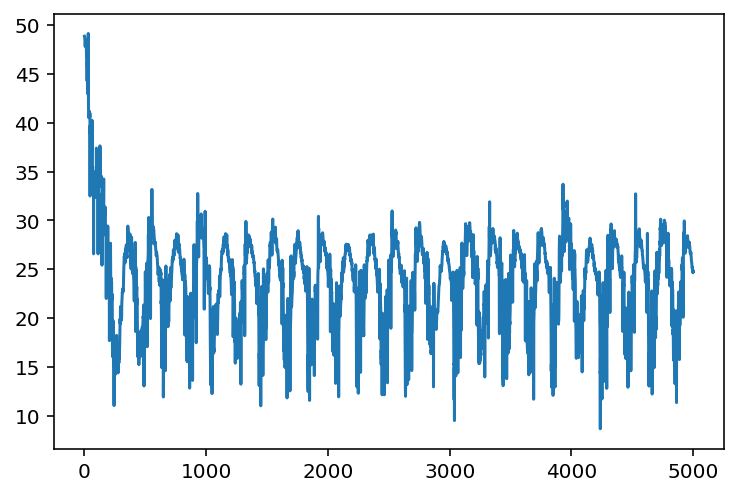

In [7]:
plt.plot(np.sum(calculated_f[:, :, 2], axis=1), label='a')

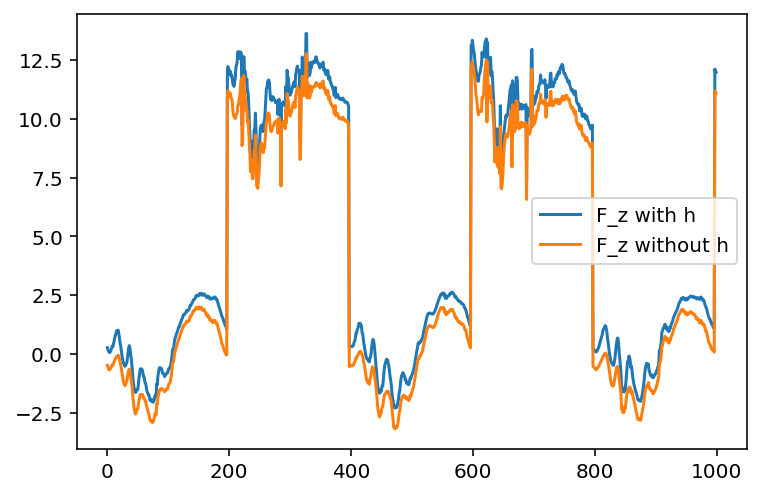

In [8]:
# f (with h) - f (without h)
slice_h = slice(1000,2000)
plt.plot(calculated_f[slice_h, 2, 2])
plt.plot(without_h[slice_h, 2, 2])
plt.legend(('F_z with h', 'F_z without h'))

In [9]:
# calculate and plot values of h (nle)
just_hs = np.empty((reader_q.shape[0], 4, 18))
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
    dq = reader_dq[ms]
    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):       
        just_hs[ms, i] = pin_robot.nle(q, dq)

#         frame_id = pin_robot.model.getFrameId(endeff_name)
#         pin_robot.framePlacement(q, index=frame_id)
#         J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
#         J_inv = np.linalg.pinv(J[:3, 6+3*i:9+3*i].T) * -1
# #         h = pin_robot.nle(q, dq)
#         # h = np.zeros(18)
#         F = np.hstack((np.zeros(6), reader_tau[ms][6:]))
#         without_h[ms, i] = J_inv @ ((F - h)[6+3*i:9+3*i])

# for i in range(18):
#     print(i)
#     plt.plot(just_hs[:, 2, i], label=str(i))
#     plt.legend()
#     plt.show()

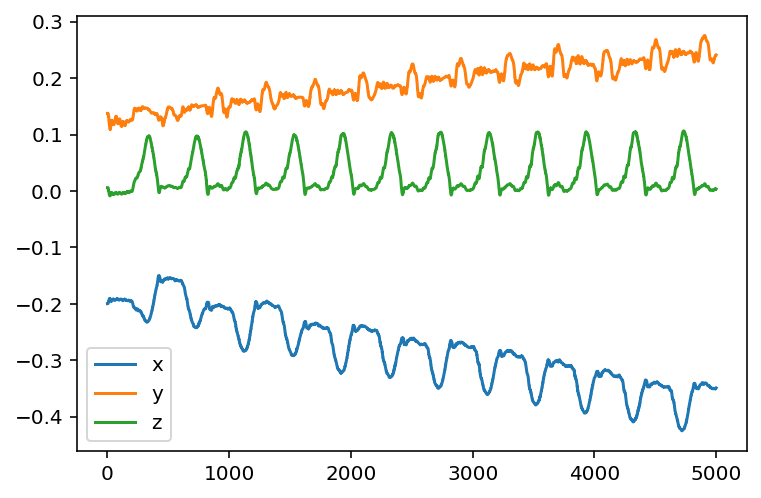

In [10]:
# plot xyz of forward kinematics
forwardK = np.empty((reader_q.shape[0], 3))
# for i_omi in range(1, 14):
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
#     dq = all_dq[ms]
    pin_robot.computeJointJacobians(q)
#     pin_robot.forwardKinematics(q)
    pin_robot.framesForwardKinematics(q)
    forwardK[ms] = pin_robot.data.oMf[pin_robot.model.getFrameId('HL_ANKLE')].translation

plt.plot(forwardK)
plt.legend('xyz')
plt.show()

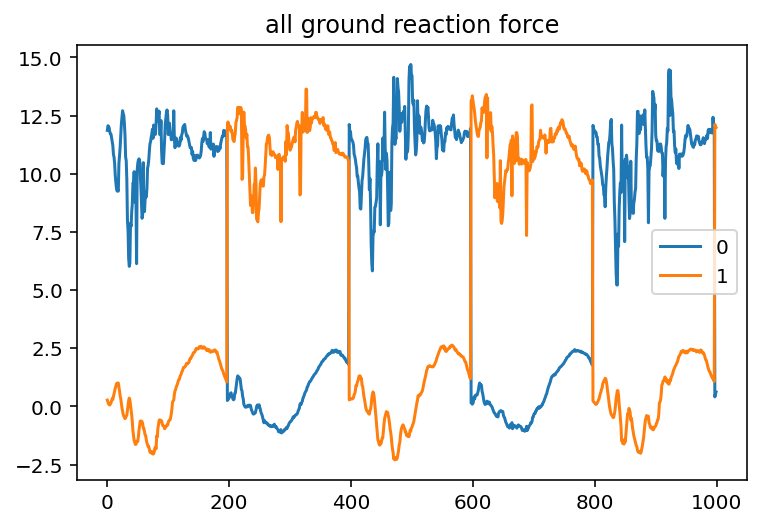

In [11]:
# plot GRF
plt.plot(calculated_f[1000:2000, ::2, 2])
plt.title('all ground reaction force')
plt.legend(range(4))

Text(0.5, 1.0, "sum of all legs' forces")

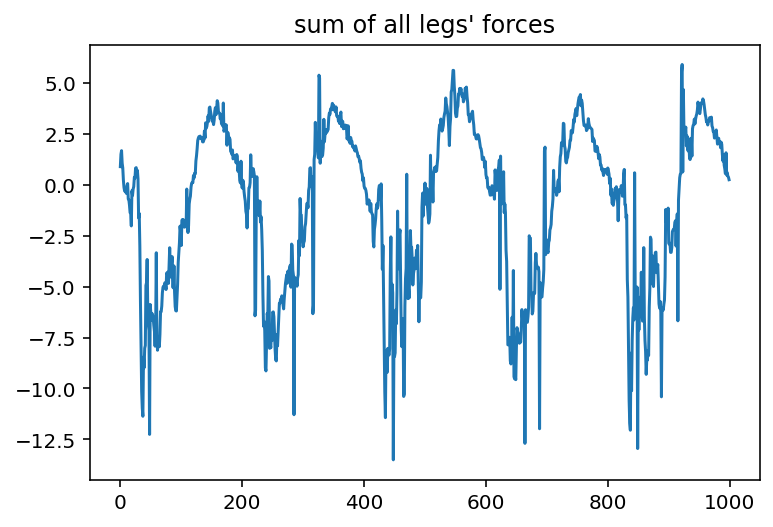

In [12]:
# plot the sum of all leg forces
m_robot = np.sum([i.mass for i in pin_robot.model.inertias])
plt.plot(np.sum(calculated_f[1000:2000, :, 2], axis=1) - m_robot * 9.81)
plt.title("sum of all legs' forces")

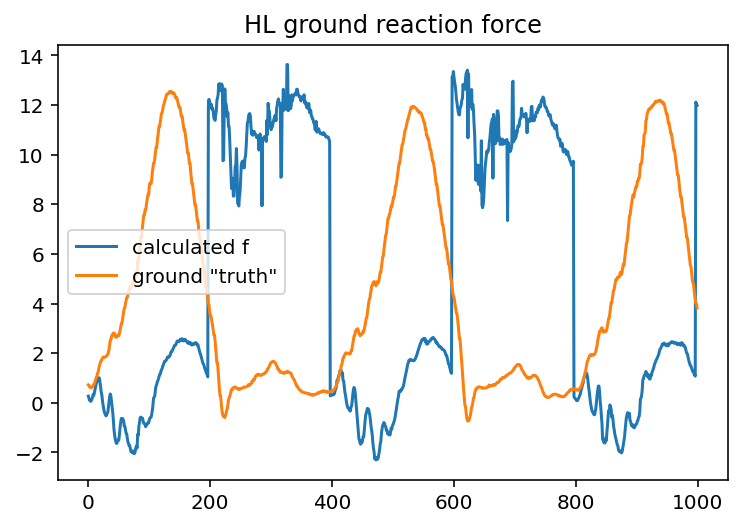

In [13]:
# compare calculated f and z values of forward kinematics
plt.plot(calculated_f[1000:2000, 2, 2])
plt.plot(forwardK[1000:2000, 2] * 120)
# plt.plot(all_imu[1000:2000, 0] * 8)
plt.title('HL ground reaction force')
plt.legend(('calculated f','ground "truth"'))
# plt.legend()

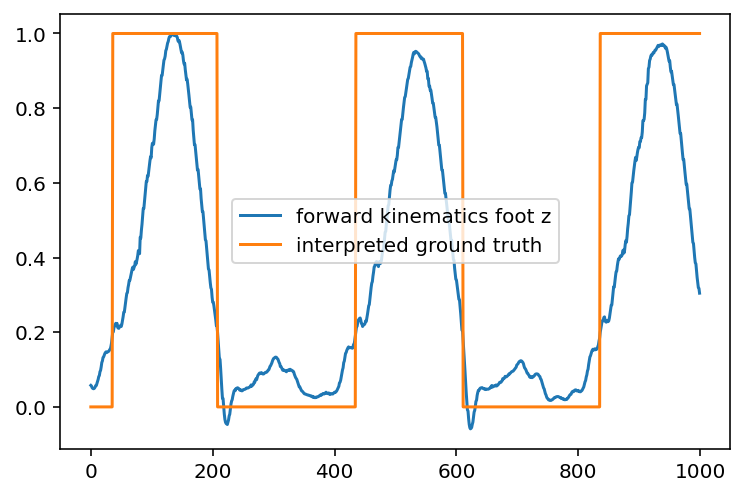

In [14]:
plt.plot(forwardK[1000:2000, 2]/np.max(forwardK[1000:2000:, 2]), label='forward kinematics foot z')
plt.plot(np.where(forwardK[1000:2000, 2]/np.max(forwardK[1000:2000:, 2]) > 0.2, 1, 0), label='interpreted ground truth')
plt.plot()
plt.legend()

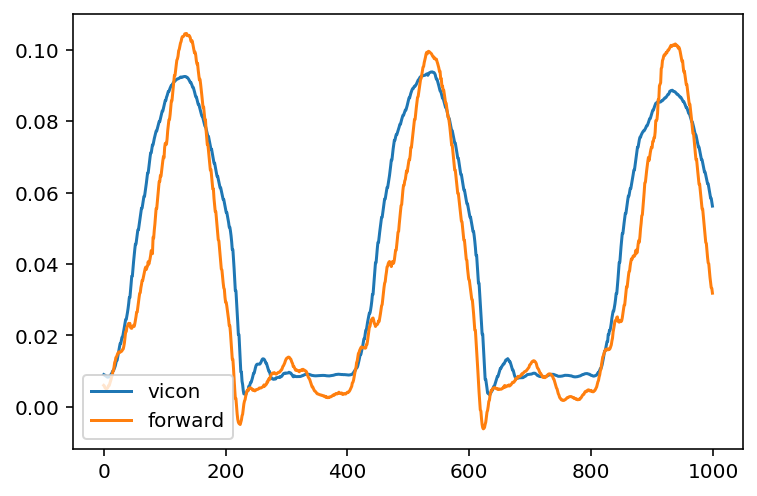

In [15]:
slice_compare_viconforwardK = slice(1000,2000)
plt.plot(reader_vicon_leg[slice_compare_viconforwardK, 2], label='vicon')
plt.plot(forwardK[slice_compare_viconforwardK, 2], label='forward')
plt.legend()

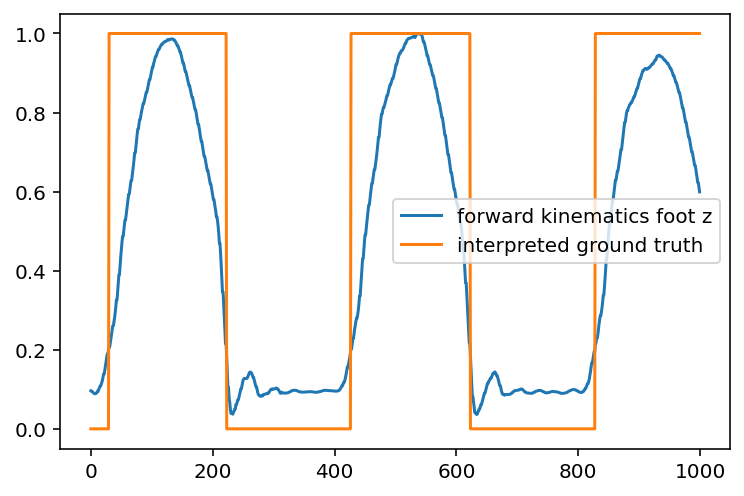

In [16]:
plt.plot(reader_vicon_leg[1000:2000, 2]/np.max(reader_vicon_leg[1000:2000:, 2]), label='forward kinematics foot z')
plt.plot(np.where(reader_vicon_leg[1000:2000, 2]/np.max(reader_vicon_leg[1000:2000:, 2]) > 0.2, 1, 0), label='interpreted ground truth')
plt.plot()
plt.legend()

Text(0.5, 1.0, 'body')

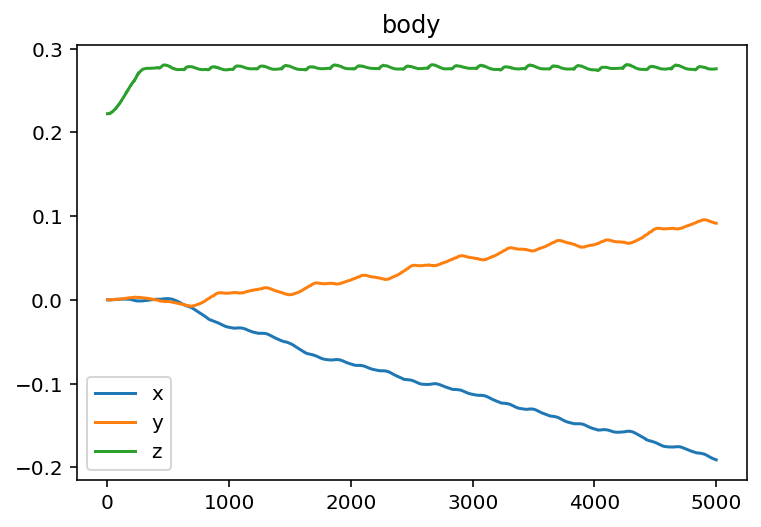

In [17]:
plt.plot(reader_q[:, :3])
plt.legend('xyz')
plt.title('body')

In [18]:
# quaterions
# plt.plot(reader_q[:, 3:7])

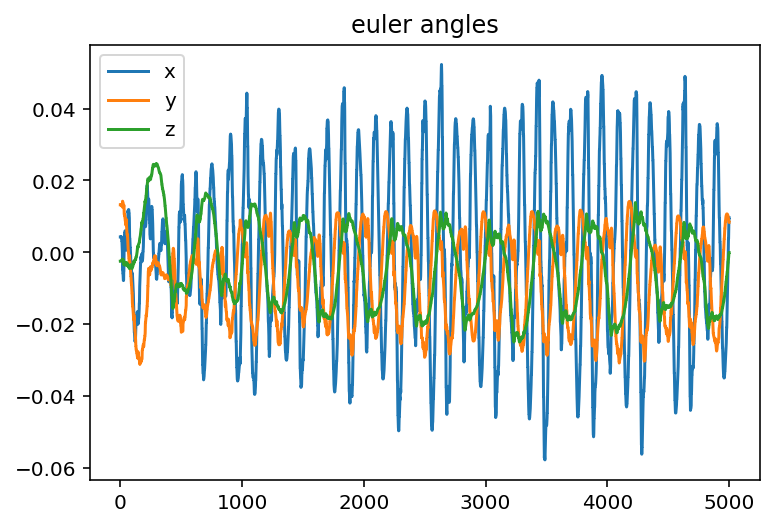

In [19]:
calculated_euler_angles = Rotation.from_quat(reader_q[:, 3:7]).as_euler('xyz')
plt.plot(calculated_euler_angles)
plt.title('euler angles')
plt.legend('xyz')

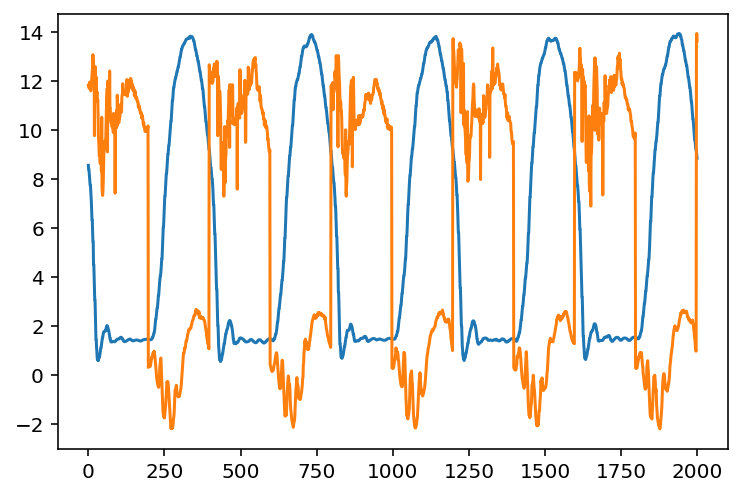

In [20]:
slice_viconcalculatedF = slice(2000, 4000)
plt.plot(reader_vicon_leg[slice_viconcalculatedF, 2] * 1/np.max(reader_vicon_leg[slice_viconcalculatedF, 2]) * np.max(calculated_f[slice_viconcalculatedF, 2, 2]))
plt.plot(calculated_f[slice_viconcalculatedF, 2, 2])

In [21]:
np.sum([i.mass for i in pin_robot.model.inertias]) * 9.81
# 24.5

24.525027369900005

# Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [23]:
# input is GRF: x, want to estimate "ground truth": y
x = calculated_f[:, 2, 2]
y = np.where(reader_vicon_leg[:, 2] > 0.02, 1, 0)  # vicon less noisy than forwward kinematics data

print(f"x shape: {x.shape}\ny shape: {y.shape}")

x shape: (5001,)
y shape: (5001,)


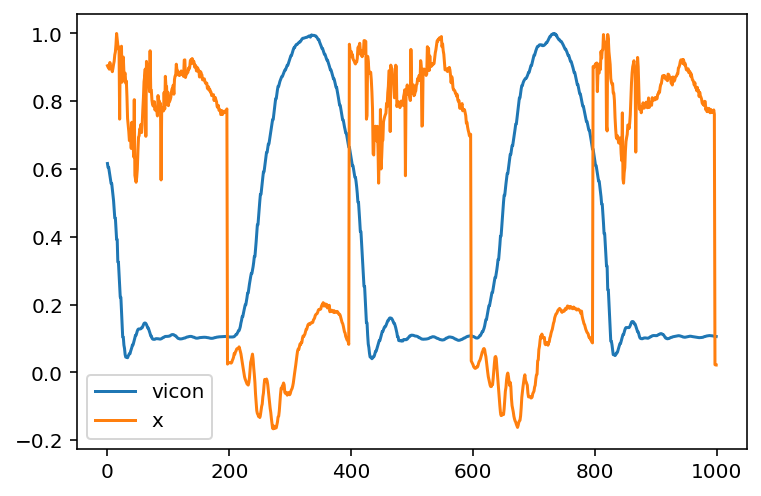

In [24]:
slice_y_vicon = slice (2000, 3000)
# plt.plot(y[slice_y_vicon], label='y')
plt.plot(reader_vicon_leg[slice_y_vicon, 2]/np.max(reader_vicon_leg[slice_y_vicon, 2]), label='vicon')
plt.plot(x[slice_y_vicon] / np.max(x[slice_y_vicon]), label='x')
plt.legend()

In [25]:
x_scale = MinMaxScaler()

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

x_train = x_scale.fit_transform(x_train.reshape((x_train.shape[0], 1)))
x_test = x_scale.transform(x_test.reshape(x_test.shape[0], 1))
# y_2d_train = y_train.reshape((y_train.shape[0], 1))
# y_2d_test = y_test.reshape((y_test.shape[0], 1))


In [26]:
logreg = LogisticRegression(C=10000000000000)

logreg.fit(x_train, y_train)

# training accuracy
y_hat_train = logreg.predict(x_train)
print("train acc:", np.mean(np.equal(y_hat_train, y_train)))

# testing accuracy
y_hat_test = logreg.predict(x_test)
print("test acc: ", np.mean(np.equal(y_hat_test, y_test)))


train acc: 0.8546666666666667
test acc:  0.8633093525179856


In [27]:
print((logreg.coef_.shape), (logreg.intercept_))

(1, 1) [ 2.28]


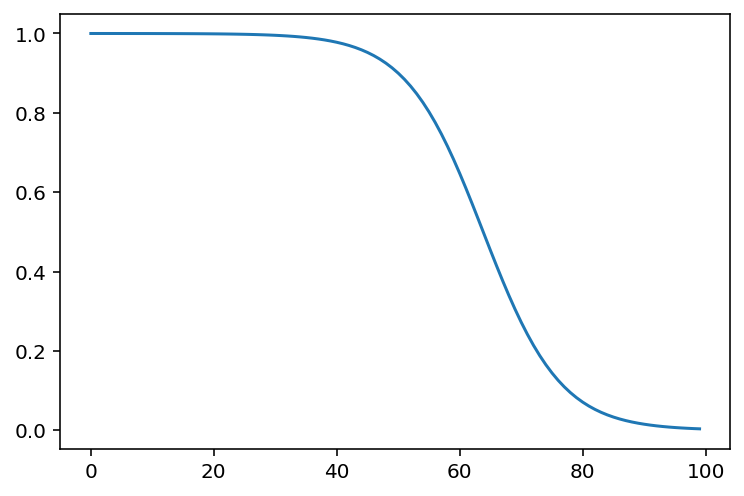

In [28]:
def sigmoid(x):
    return 1/(1+np.exp(-x * logreg.coef_[0][0] - logreg.intercept_[0]))

plt.plot(sigmoid(np.linspace(-1, 1, 100)))

In [29]:
print("train\n", confusion_matrix(y_train, y_hat_train))
print("test\n", confusion_matrix(y_test, y_hat_test))

train
 [[1702  316]
 [ 229 1503]]
test
 [[584  89]
 [ 82 496]]


# M @ ddq

In [30]:
calculated_ddq = np.gradient(reader_dq, axis=0)  # q dot dot
print(calculated_ddq.shape)

(5001, 18)


In [38]:
M = np.array(list(i.mass for i in pin_robot.model.inertias))

# 3 copies of root joint mass for xyz, 3 zeros for angle vel, limb masses for each of the other
M = np.hstack((np.full(3, M[1]), np.zeros(3), (M[2:])))
# M = np.hstack((np.zeros(6), (M[2:])))

print(M.shape)

(18,)


In [39]:
with_ddq = np.empty((reader_q.shape[0], 4, 3))
for ms in range(reader_q.shape[0]):
    q = reader_q[ms]
    dq = reader_dq[ms]
    ddq = calculated_ddq[ms]
    pin_robot.computeJointJacobians(q)

    for i, endeff_name in enumerate(['FL_ANKLE', 'FR_ANKLE', 'HL_ANKLE', 'HR_ANKLE']):             
        frame_id = pin_robot.model.getFrameId(endeff_name)
        pin_robot.framePlacement(q, index=frame_id)
        J = pin_robot.getFrameJacobian(frame_id=frame_id, rf_frame=pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_inv = np.linalg.pinv(J[:3, 6+3*i:9+3*i].T) * -1
        h = pin_robot.nle(q, dq)
        t = np.hstack((np.zeros(6), reader_tau[ms][6:]))
        _a = M.T @ ddq
        with_ddq[ms, i] = J_inv @ ((t - h - _a)[6+3*i:9+3*i])

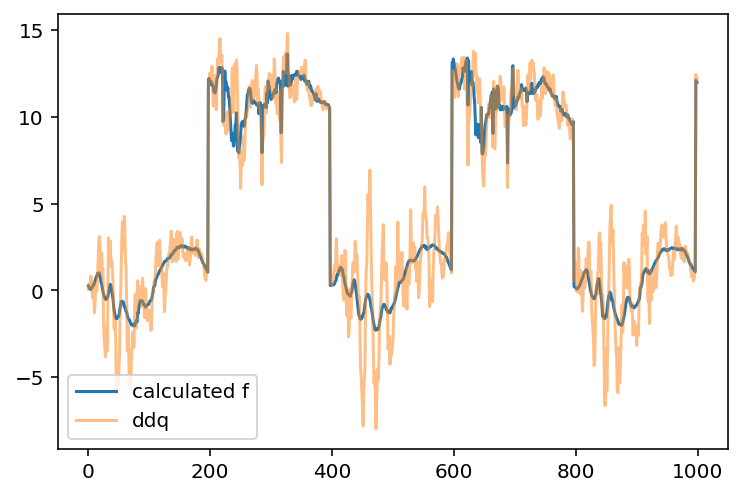

In [43]:
slice_ddq = slice(1000,2000)
plt.plot(calculated_f[slice_ddq, 2, 2], label='calculated f')
plt.plot(with_ddq[slice_ddq, 2, 2], label='ddq', alpha=0.5)
plt.legend()